In [7]:
import utils

In [8]:
# 一次性加载多个文件（示例1：明确列出文件名）
# df = utils.load_multiple(files=["datasample.csv"], path="./", sample=-1, add_source=False)

# 示例2：使用通配符从 matched 目录加载所有 csv，并记录来源文件名
# 注意：数据量可能很大，可将 sample 设置为较小值进行抽样预览
# df = utils.load_multiple(glob_pattern="matched/*.csv", path="./", sample=5000, add_source=True)

# 下面默认继续沿用原始单文件加载，保持笔记本其他单元兼容
df = utils.load_multiple(["datasample.csv", "Transaction Data 09232025.csv"], sample = -1)

In [9]:
df.columns

Index(['Account ID', 'Member ID', 'Account Type', 'Account Open Date',
       'Member Age', 'Product ID', 'Post Date', 'Post Time', 'Amount',
       'Action Type', 'Source Type', 'Transaction Description',
       'Fraud Adjustment Indicator'],
      dtype='object')

In [10]:
import pandas as pd
df["Amount"] = df["Amount"].replace('[\$,]', '', regex=True).astype(float)
df["Post Time"] = df["Post Time"].astype(int)

In [11]:
df["Post Date"] = pd.to_datetime(df["Post Date"])
df["Account Open Date"] = pd.to_datetime(df["Account Open Date"])

In [12]:
cat_features = ["Account Type", "Action Type", "Source Type", "Product ID"]
uni_vals = {}
for col in cat_features:
    uni_vals[col] = {v:i for i, v in enumerate(df[col].unique())}

In [13]:
print(
    {k: len(v) for k, v in uni_vals.items()}
)

{'Account Type': 15, 'Action Type': 4, 'Source Type': 19, 'Product ID': 105}


In [14]:
df['Fraud Adjustment Indicator'].unique()

array([nan, '12/30 LAKEVIEW CARE RETURN-UNAUTH TRANS',
       '12/31 ALLY RETURN-UNAUTH TRANS', 'REFUND UNAUTHORIZED ZELLE TRF',
       'RTN PAYPAL 12/2 UNAUTH', 'RTN PAYPAL 11/14 UNAUTH',
       '12/30 DONG GUAN QIAN RETURN-UNAUTH TRANS',
       '12/27 PAYPAL RETURN-UNAUTH TRANS', 'RTN KGVPN 1/7 UNAUTH',
       'RTN KGVPN 12/9 UNAUTH', 'RTN PAYPAL 12/23 UNAUTH',
       'RTN PAYPAL 12/31 UNAUTH',
       '1/13 ALEPPO TOWNSHIP RETURN-UNAUTH TRANS',
       'PROV CR CK#2108,12/9/24,FRAUD,ENCOMPASS',
       'PROV CR CK#7278,12/9/24,FRAUD,ENCOMPASS',
       'PROV CR CK#7304,12/13/24,FRAUD,ENCOMPASS',
       '1/22 LENDINGPOINT LLC RETURN-UNAUTH TRANS',
       '12/18 PAYPAL RETURN-UNAUTH TRANS', 'RTN DUQUESNE LIGHT UNAUTH',
       '1/31 SNAP FINANCE RETURN-UNAUTH TRANS',
       '1/31 BARCLAYCARD US RETURN-UNAUTH TRANS',
       '12/23 SPARTA PAYMENTS RETURN-UNAUTH TRANS',
       '1/29 GM FINANCIAL RETURN-UNAUTH TRANS',
       '1/14 GM FINANCIAL RETURN-UNAUTH TRANS',
       '1/29 GEICO RETURN-UN

In [15]:
for col in cat_features:
    df[col+'_enc'] = df[col].map(uni_vals[col])

In [16]:
df['Fraud'] =  df["Fraud Adjustment Indicator"].notna().astype(int)

In [17]:
def parse_post_time(x):
    s = str(x).zfill(6) 
    hh, mm, ss = int(s[0:2]), int(s[2:4]), int(s[4:6])
    return pd.to_datetime(f"{hh}:{mm}:{ss}", format="%H:%M:%S").time()

df["Post Time Parsed"] = df["Post Time"].apply(parse_post_time)
print(df[["Post Time", "Post Time Parsed"]].head())

   Post Time Post Time Parsed
0         16         00:00:16
1         37         00:00:37
2         46         00:00:46
3         49         00:00:49
4         54         00:00:54


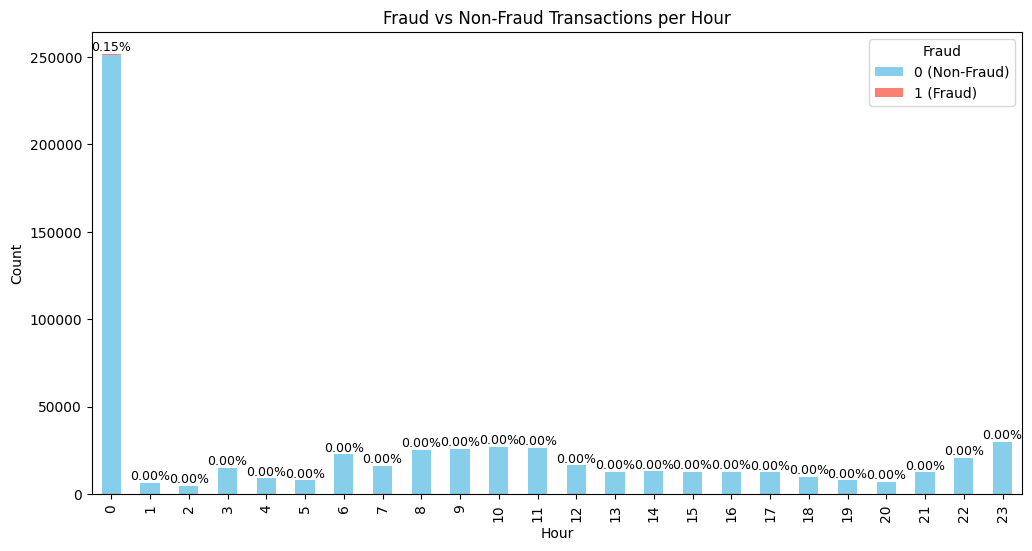

In [95]:
import matplotlib.pyplot as plt

# 提取小时
df["hour"] = df["Post Time Parsed"].apply(lambda t: t.hour)

# 按小时 & Fraud 分组计数
counts = df.groupby(["hour", "Fraud"]).size().unstack(fill_value=0)

# 绘制堆叠柱状图
ax = counts.plot(
    kind="bar",
    stacked=True,
    color={0: "skyblue", 1: "salmon"},
    figsize=(12,6)
)

plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Fraud vs Non-Fraud Transactions per Hour")
plt.legend(title="Fraud", labels=["0 (Non-Fraud)", "1 (Fraud)"])

# 计算 fraud 占比
fraud_ratio = counts[1] / counts.sum(axis=1)

# 在柱子上方添加标注
for idx, (total, ratio) in enumerate(zip(counts.sum(axis=1), fraud_ratio)):
    if total > 0:  # 避免除以0
        ax.text(
            idx, total + 1,                    # 柱子顶部 + 一点偏移
            f"{ratio:.2%}",                    # 百分比格式
            ha="center", va="bottom", fontsize=9, color="black"
        )

plt.show()

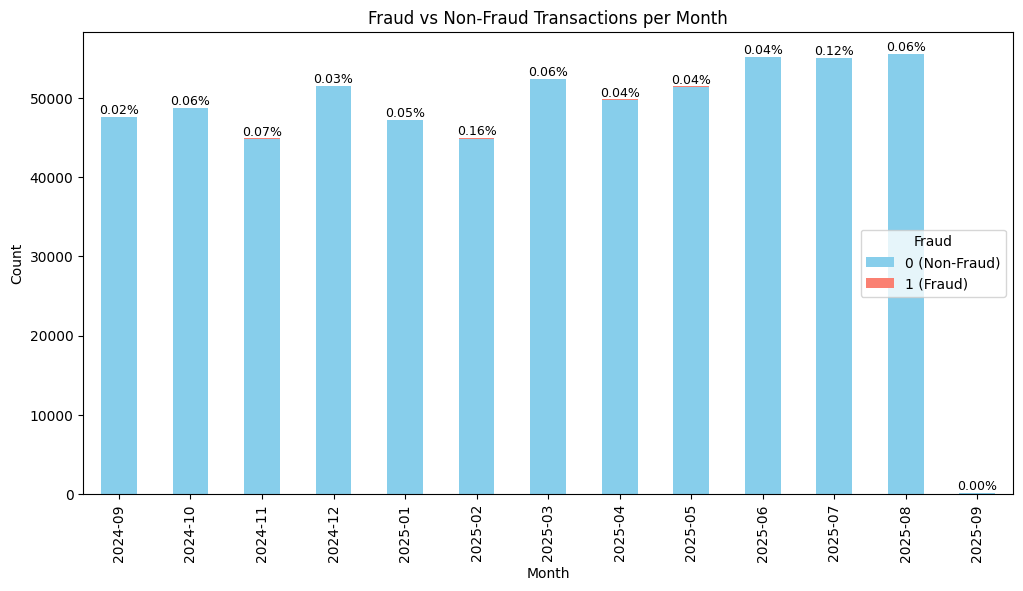

In [96]:
df["month"] = df["Post Date"].dt.to_period("M")

# 按月份 & Fraud 分组计数
counts = df.groupby(["month", "Fraud"]).size().unstack(fill_value=0)

# 绘制堆叠柱状图
ax = counts.plot(
    kind="bar",
    stacked=True,
    color={0: "skyblue", 1: "salmon"},
    figsize=(12,6)
)

plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Fraud vs Non-Fraud Transactions per Month")
plt.legend(title="Fraud", labels=["0 (Non-Fraud)", "1 (Fraud)"])

# 计算 fraud 占比
fraud_ratio = counts[1] / counts.sum(axis=1)

# 在柱子上方标注
for idx, (total, ratio) in enumerate(zip(counts.sum(axis=1), fraud_ratio)):
    if total > 0:
        ax.text(
            idx, total + 1,
            f"{ratio:.2%}",   # 显示百分比
            ha="center", va="bottom", fontsize=9, color="black"
        )

plt.show()
del df['month']

In [19]:
for id in df['Account ID'].unique():
    df[df['Account ID'] == id]\
        .sort_values(by=["Post Date", "Post Time"])\
        [
    ["Account Type_enc", 'Account Open Date',
       'Member Age', 'Product ID_enc', 'Post Date', 'Post Time Parsed', 'Amount',
    
       'Action Type_enc', 'Source Type_enc',
       'Fraud Adjustment Indicator']
].to_csv(f"./data/{id}.csv", index=False, encoding="utf-8-sig")
    

In [30]:

for id in df['Account ID'].unique():
    if 1 not in df[df['Account ID'] == id]['Fraud'].unique():
        continue
    df[df['Account ID'] == id] \
        .sort_values(by=["Post Date", "Post Time"]) \
        [
        ["Account Type", 'Account Open Date',
         'Member Age', 'Product ID', 'Post Date', 'Post Time Parsed', 'Amount',

         'Action Type', 'Source Type',
         "Fraud Adjustment Indicator"]
    ].to_csv(f"./data_analysis/{id}.csv", index=False, encoding="utf-8-sig")



In [20]:
def fast_extract_date(text):
    if pd.isna(text):
        return None
    # 先把逗号替换成空格，再 split
    tokens = str(text).replace(",", " ").split()
    for token in tokens:
        if "/" in token:
            parts = token.split("/")
            if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
                m, d = int(parts[0]), int(parts[1])
                if 1 <= m <= 12 and 1 <= d <= 31:
                    return f"{m}/{d}"
    return None



In [21]:
def match_row(row, df):
    idx = row.name  # 当前行索引

    # 情况2: Fraud Adjustment Indicator 为空，直接退出
    if pd.isna(row["Fraud Adjustment Indicator"]):
        return -1

    # 确保存在标记列用于避免重复匹配
    if "_matched" not in df.columns:
        df["_matched"] = False

    # 按规则筛选候选集合
    if pd.notna(row.get("fraud_date")):
        candidates = df[(df["Post Date"] == row["fraud_date"]) & (df["Amount"] == row["Amount"])]
    else:
        candidates = df[(df["Amount"] == row["Amount"]) & (df.index < idx)]

    # 排除已匹配过的记录与自身
    if "_matched" in candidates.columns:
        candidates = candidates[~candidates["_matched"]]
    candidates = candidates[candidates.index != idx]

    match_list = candidates.index.tolist()
    if match_list:
        chosen = match_list[0]
        # 立即标记，后续会跳过该记录，实现“非 first-fit 可持续匹配”
        df.at[chosen, "_matched"] = True
        return chosen

    print(f"cant find match for df {idx}")
    return -1

# df = utils.load_data("89413929.csv","history_data/", sample = -1)
# df["Post Date"] = pd.to_datetime(df["Post Date"])
# df["fraud_date_str"] = df["Fraud Adjustment Indicator"].apply(fast_extract_date)
# df["fraud_date"] = pd.to_datetime(
#         df["fraud_date_str"].astype(str) + "/" + df["Post Date"].dt.year.astype(str),
#         errors="coerce"
#     )
# if "_matched" not in df.columns:
#     df["_matched"] = False
# df["matches"] = df.apply(lambda row: match_row(row, df), axis=1)
# rows_to_drop = []
# for idx, row in df.iterrows():
#     if row["matches"] >= 0:  # 有匹配
#         df.loc[row["matches"], "Fraud"] = 1
#         df.loc[row["matches"], "Fraud Description"] = row["Fraud Adjustment Indicator"]
#         rows_to_drop.append(idx)
# df = df.drop(rows_to_drop)
# del df["matches"]
# del df["fraud_date"]
# del df['fraud_date_str']
# del df['Fraud Adjustment Indicator']
# if "_matched" in df.columns:
#     del df["_matched"]


In [ ]:
df.to_csv("test.csv", index=False, encoding="utf-8-sig")


In [23]:
df = utils.load_data("89413929.csv","history_data/", sample = -1)

df[df["Fraud Adjustment Indicator"].notna()]

,Account Type_enc,Account Open Date,Member Age,Product ID_enc,Post Date,Post Time Parsed,Amount,Action Type_enc,Source Type_enc,Fraud Adjustment Indicator
228,0,2022-12-15,22,86,2025-08-29,00:10:11,500.0,0,4,08/28 MOB DEP RET PER FRAUD DEPT
229,0,2022-12-15,22,86,2025-08-29,00:10:11,500.0,0,4,08/28 MOB DEP RET PER FRAUD DEPT
230,0,2022-12-15,22,86,2025-08-29,00:10:12,500.0,0,4,08/28 MOB DEP RET PER FRAUD DEPT
231,0,2022-12-15,22,86,2025-08-29,00:10:13,500.0,0,4,08/28 MOB DEP RET PER FRAUD DEPT
232,0,2022-12-15,22,86,2025-08-29,00:10:14,500.0,0,4,08/28 MOB DEP RET PER FRAUD DEPT
233,0,2022-12-15,22,86,2025-08-29,00:10:15,500.0,0,4,08/28 MOB DEP RET PER FRAUD DEPT


In [22]:
import glob
import os
import shutil

folder = "history_data/"
matched_dir = "matched/"
unmatched_dir = "unmatched/"
no_fraud_dir = "no_fraud/"
os.makedirs(matched_dir, exist_ok=True)
os.makedirs(unmatched_dir, exist_ok=True)
os.makedirs(no_fraud_dir, exist_ok=True)

# 统一列规范：确保 Fraud 列为 0/1，补齐 Fraud Description，并移除辅助列与 Indicator

def normalize_columns(df):
    if "Fraud" in df.columns:
        df["Fraud"] = (df["Fraud"] == 1).astype(int)
    else:
        df["Fraud"] = 0
    if "Fraud Description" not in df.columns:
        df["Fraud Description"] = ""
    for col in ["matches", "fraud_date", "fraud_date_str", "_matched"]:
        if col in df.columns:
            del df[col]
    if "Fraud Adjustment Indicator" in df.columns:
        del df["Fraud Adjustment Indicator"]
    return df

# 找到所有 csv 文件
csv_files = glob.glob(os.path.join(folder, "*.csv"))

# 遍历处理（不修改 history_data 源文件）
for file in csv_files:
    df = pd.read_csv(file)

    # 预处理（仅内存中）
    df["Post Date"] = pd.to_datetime(df["Post Date"])
    df["fraud_date_str"] = df["Fraud Adjustment Indicator"].apply(fast_extract_date) if "Fraud Adjustment Indicator" in df.columns else ""
    df["fraud_date"] = pd.to_datetime(
        df["fraud_date_str"].astype(str) + "/" + df["Post Date"].dt.year.astype(str),
        errors="coerce"
    ) if "fraud_date_str" in df.columns else pd.NaT
    if "_matched" not in df.columns:
        df["_matched"] = False

    # 计算匹配（若无 Indicator 列则跳过匹配）
    if "Fraud Adjustment Indicator" in df.columns:
        df["matches"] = df.apply(lambda row: match_row(row, df), axis=1)
        fraud_mask = df["Fraud Adjustment Indicator"].notna()
        num_fraud = int(fraud_mask.sum())
    else:
        df["matches"] = -1
        fraud_mask = pd.Series([False] * len(df), index=df.index)
        num_fraud = 0

    basename = os.path.basename(file)

    if num_fraud == 0:
        # 无任何 Fraud Indicator → 输出到 no_fraud（标准化列）
        out_df = normalize_columns(df.copy())
        out_df.to_csv(os.path.join(no_fraud_dir, basename), index=False, encoding="utf-8-sig")
    else:
        all_matched = (df.loc[fraud_mask, "matches"] >= 0).all()
        if all_matched:
            # 应用匹配：标记被匹配交易为 Fraud，删除带 indicator 的行
            rows_to_drop = []
            for idx, row in df.iterrows():
                if row["matches"] >= 0:
                    df.loc[row["matches"], "Fraud"] = 1
                    df.loc[row["matches"], "Fraud Description"] = row.get("Fraud Adjustment Indicator", "")
                    rows_to_drop.append(idx)
            df = df.drop(rows_to_drop)
            out_df = normalize_columns(df)
            out_df.to_csv(os.path.join(matched_dir, basename), index=False, encoding="utf-8-sig")
        else:
            # 未完全匹配 → 输出到 unmatched（标准化列），不改动源文件
            out_df = normalize_columns(df.copy())
            out_df.to_csv(os.path.join(unmatched_dir, basename), index=False, encoding="utf-8-sig")



C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 2
cant find match for df 3


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 740


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 53


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 16
cant find match for df 17


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 388


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 250


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 436
cant find match for df 479
cant find match for df 480
cant find match for df 481
cant find match for df 482
cant find match for df 483
cant find match for df 485
cant find match for df 486


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 64


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 738


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 1239


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 288


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 1


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 0


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 418
cant find match for df 423


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 111


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 965
cant find match for df 966
cant find match for df 967
cant find match for df 968
cant find match for df 969
cant find match for df 970


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 583
cant find match for df 584


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 20
cant find match for df 21
cant find match for df 22
cant find match for df 23


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 52


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 3


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 664


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 437
cant find match for df 438
cant find match for df 439
cant find match for df 440


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2256232498.py:39: UserWarning: Could not infer format, so each element will be parsed i

# Next are the analysis part

In [62]:
df = utils.load_data("9180164404.csv", "./data_analysis/", sample = -1)

In [63]:
df.columns


Index(['Account Type', 'Account Open Date', 'Member Age', 'Product ID',
       'Post Date', 'Post Time Parsed', 'Amount', 'Action Type', 'Source Type',
       'Fraud', 'Fraud Description'],
      dtype='object')

[Timestamp('2025-02-24 00:00:00'), Timestamp('2025-02-25 00:00:00'), Timestamp('2025-02-25 00:00:00'), Timestamp('2025-02-27 00:00:00'), Timestamp('2025-02-28 00:00:00'), Timestamp('2025-03-04 00:00:00'), Timestamp('2025-03-06 00:00:00'), Timestamp('2025-03-11 00:00:00'), Timestamp('2025-03-11 00:00:00'), Timestamp('2025-05-13 00:00:00'), Timestamp('2025-06-27 00:00:00')] 2024-09-01


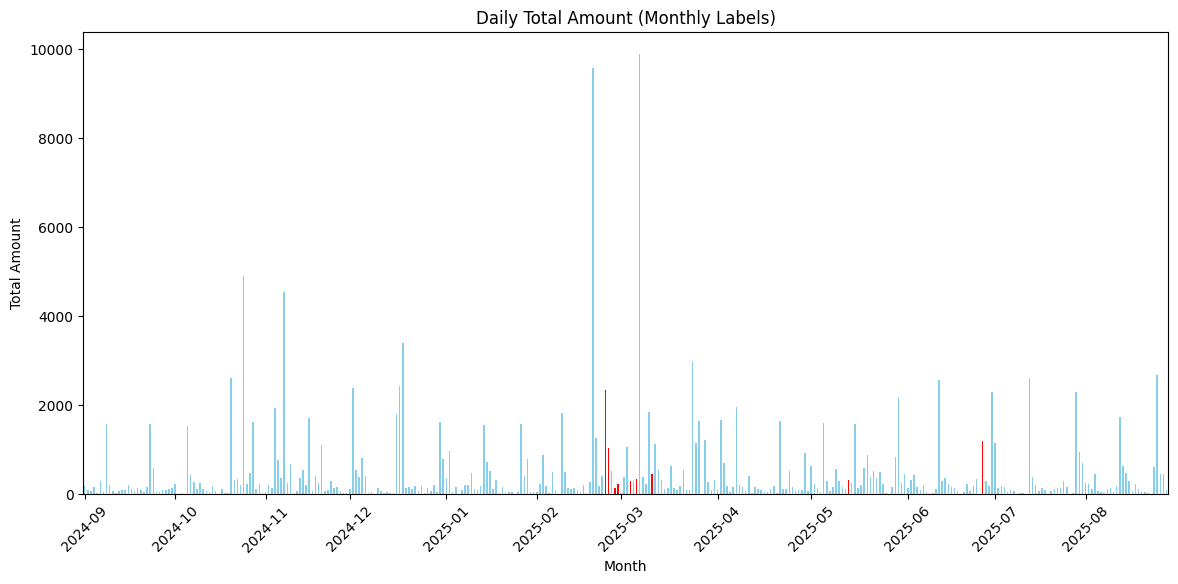

In [64]:
import matplotlib.pyplot as plt
# 按天统计 Amount
df["Post Date"] = pd.to_datetime(df["Post Date"])
daily_amount = df.groupby(df["Post Date"].dt.date)["Amount"].sum()
target_date = df[df["Fraud"].notna()]["Post Date"].tolist()
print(target_date, daily_amount.index[0])
# 设置颜色：指定日期红色，其余蓝色
colors = ["red" if pd.to_datetime(date) in target_date else "skyblue" for date in daily_amount.index]
# 画柱状图
fig, ax = plt.subplots(figsize=(14,6))
daily_amount.plot(kind="bar", color=colors, ax=ax)

# 找到每个月的第一个日期
first_of_month = daily_amount.groupby(pd.to_datetime(daily_amount.index).to_period("M")).head(1)

# 设置 xticks 位置和标签
ax.set_xticks([daily_amount.index.get_loc(d) for d in first_of_month.index])
ax.set_xticklabels([d.strftime("%Y-%m") for d in first_of_month.index], rotation=45)

ax.set_xlabel("Month")
ax.set_ylabel("Total Amount")
ax.set_title("Daily Total Amount (Monthly Labels)")

plt.show()


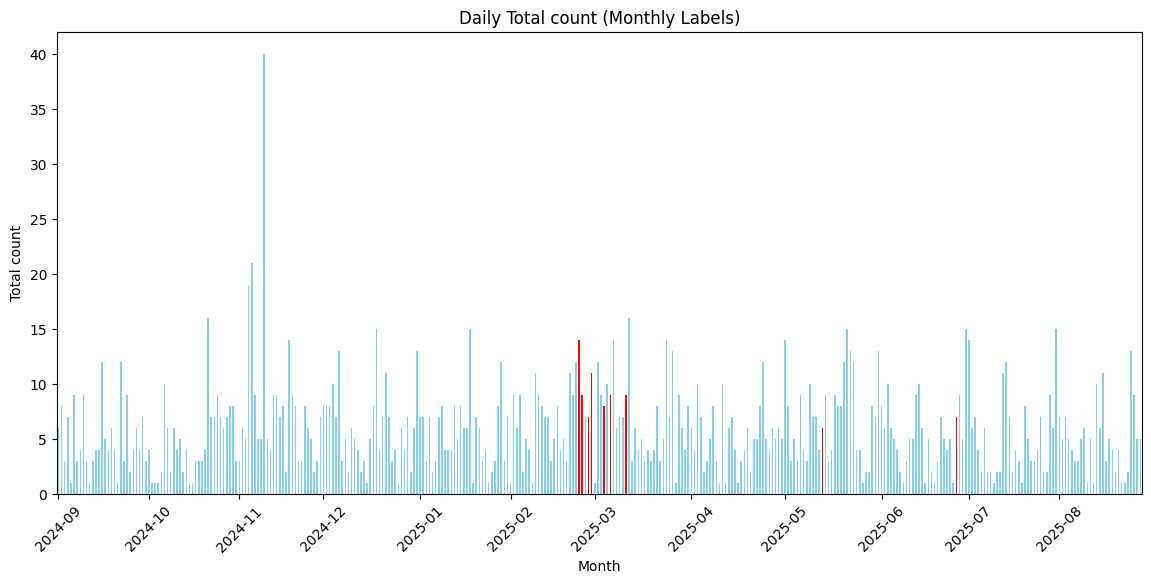

In [66]:
df["Post Date"] = pd.to_datetime(df["Post Date"])
daily_amount = df.groupby(df["Post Date"].dt.date)["Amount"].count()


# 设置颜色：指定日期红色，其余蓝色
colors = ["red" if pd.to_datetime(date) in target_date else "skyblue" for date in daily_amount.index]
# 画柱状图
fig, ax = plt.subplots(figsize=(14,6))
daily_amount.plot(kind="bar", color=colors, ax=ax)

# 找到每个月的第一个日期
first_of_month = daily_amount.groupby(pd.to_datetime(daily_amount.index).to_period("M")).head(1)

# 设置 xticks 位置和标签
ax.set_xticks([daily_amount.index.get_loc(d) for d in first_of_month.index])
ax.set_xticklabels([d.strftime("%Y-%m") for d in first_of_month.index], rotation=45)

ax.set_xlabel("Month")
ax.set_ylabel("Total count")
ax.set_title("Daily Total count (Monthly Labels)")

plt.show()

In [37]:
df['Source Type'].unique()

array(['ACH', 'Signature', 'ATM', 'Dividend', 'Fee', 'Online Banking',
       'Cash', 'Draft', nan], dtype=object)

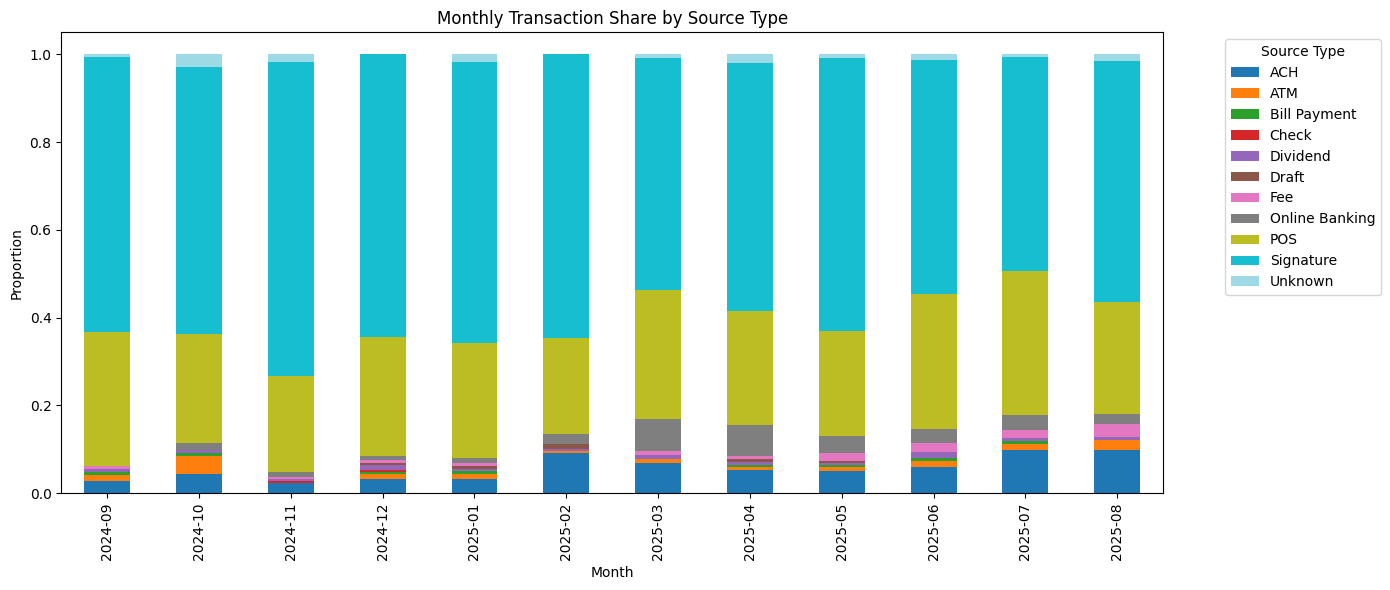

In [67]:


# 确保 Post Date 是 datetime 类型
df["Post Date"] = pd.to_datetime(df["Post Date"])
df["Source Type"] = df["Source Type"].fillna("Unknown")
# 提取月份 (YYYY-MM)
df["month"] = df["Post Date"].dt.to_period("M")

# 按月份和 Source Type 分组计数
counts = df.groupby(["month", "Source Type"]).size().unstack(fill_value=0)

# 转换为占比
ratio = counts.div(counts.sum(axis=1), axis=0)

# 绘制堆叠柱状图
ax = ratio.plot(
    kind="bar",
    stacked=True,
    figsize=(14,6),
    colormap="tab20",   # 自动分配颜色
    title="Monthly Transaction Share by Source Type"
)

ax.set_xlabel("Month")
ax.set_ylabel("Proportion")
plt.legend(title="Source Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

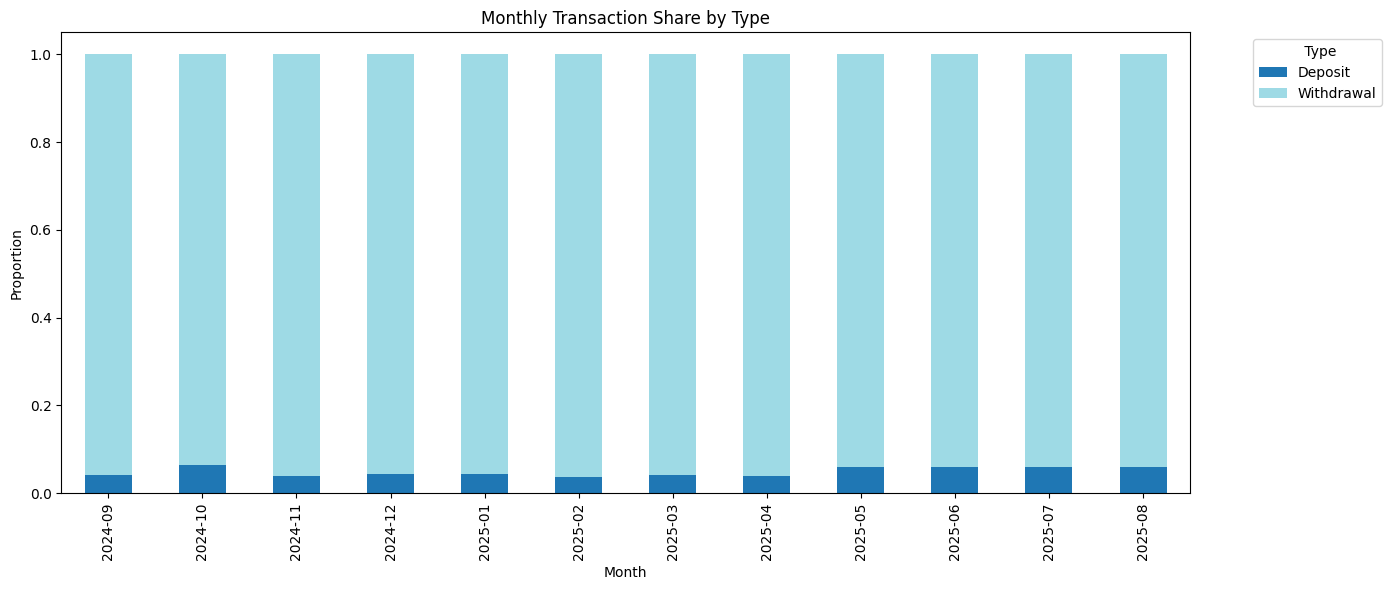

In [68]:


# 按月份和 Source Type 分组计数
counts = df.groupby(["month", "Action Type"]).size().unstack(fill_value=0)

# 转换为占比
ratio = counts.div(counts.sum(axis=1), axis=0)

# 绘制堆叠柱状图
ax = ratio.plot(
    kind="bar",
    stacked=True,
    figsize=(14,6),
    colormap="tab20",   # 自动分配颜色
    title="Monthly Transaction Share by Type"
)

ax.set_xlabel("Month")
ax.set_ylabel("Proportion")
plt.legend(title=" Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [18]:
df[df["Account ID"]==4107081595].to_csv("test.csv", index=False, encoding="utf-8-sig")

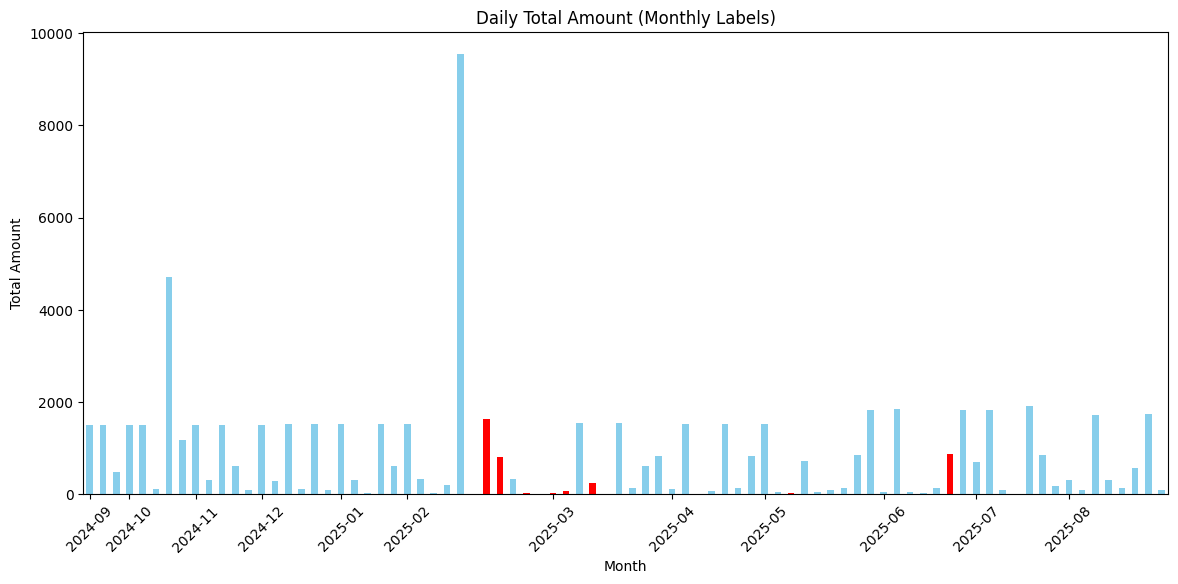

In [69]:
df = df[df["Source Type"]=="ACH"]

df["Post Date"] = pd.to_datetime(df["Post Date"])
daily_amount = df.groupby(df["Post Date"].dt.date)["Amount"].sum()

# 设置颜色：指定日期红色，其余蓝色
colors = ["red" if pd.to_datetime(date) in target_date else "skyblue" for date in daily_amount.index]
# 画柱状图
fig, ax = plt.subplots(figsize=(14,6))
daily_amount.plot(kind="bar", color=colors, ax=ax)

# 找到每个月的第一个日期
first_of_month = daily_amount.groupby(pd.to_datetime(daily_amount.index).to_period("M")).head(1)

# 设置 xticks 位置和标签
ax.set_xticks([daily_amount.index.get_loc(d) for d in first_of_month.index])
ax.set_xticklabels([d.strftime("%Y-%m") for d in first_of_month.index], rotation=45)

ax.set_xlabel("Month")
ax.set_ylabel("Total Amount")
ax.set_title("Daily Total Amount (Monthly Labels)")

plt.show()

Text(0.5, 1.0, 'Daily Total count (Monthly Labels)')

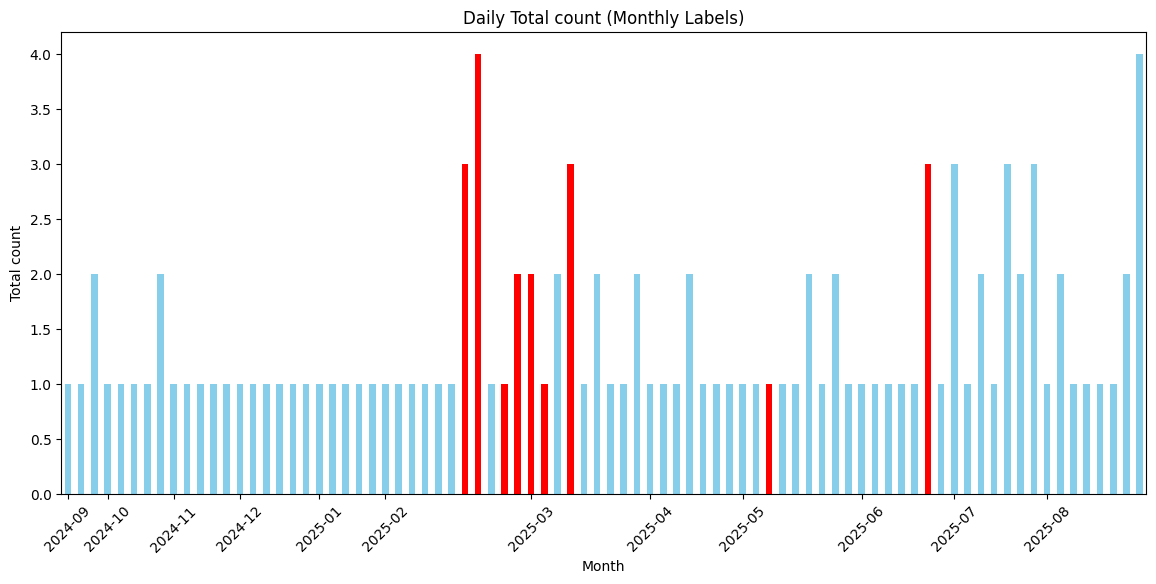

In [70]:
df["Post Date"] = pd.to_datetime(df["Post Date"])
daily_amount = df.groupby(df["Post Date"].dt.date)["Amount"].count()


# 设置颜色：指定日期红色，其余蓝色
colors = ["red" if pd.to_datetime(date) in target_date else "skyblue" for date in daily_amount.index]
# 画柱状图
fig, ax = plt.subplots(figsize=(14,6))
daily_amount.plot(kind="bar", color=colors, ax=ax)

# 找到每个月的第一个日期
first_of_month = daily_amount.groupby(pd.to_datetime(daily_amount.index).to_period("M")).head(1)

# 设置 xticks 位置和标签
ax.set_xticks([daily_amount.index.get_loc(d) for d in first_of_month.index])
ax.set_xticklabels([d.strftime("%Y-%m") for d in first_of_month.index], rotation=45)

ax.set_xlabel("Month")
ax.set_ylabel("Total count")
ax.set_title("Daily Total count (Monthly Labels)")

In [23]:
import glob
import os
import shutil

folder = "history_data/"
matched_dir = "matched/"
unmatched_dir = "unmatched/"
no_fraud_dir = "no_fraud/"
os.makedirs(matched_dir, exist_ok=True)
os.makedirs(unmatched_dir, exist_ok=True)
os.makedirs(no_fraud_dir, exist_ok=True)

# 规范输出列：可选择是否保留 Fraud Adjustment Indicator；移除临时辅助列；统一 Fraud 列为 0/1；补齐 Fraud Description

def normalize_and_save(out_df, out_path, keep_indicator: bool = False):
    if "Fraud" in out_df.columns:
        out_df["Fraud"] = (out_df["Fraud"] == 1).astype(int)
    else:
        out_df["Fraud"] = 0
    if "Fraud Description" not in out_df.columns:
        out_df["Fraud Description"] = ""
    for col in ["matches", "fraud_date", "fraud_date_str", "_matched"]:
        if col in out_df.columns:
            del out_df[col]
    if not keep_indicator and "Fraud Adjustment Indicator" in out_df.columns:
        del out_df["Fraud Adjustment Indicator"]
    out_df.to_csv(out_path, index=False, encoding="utf-8-sig")

# 找到所有 csv 文件
csv_files = glob.glob(os.path.join(folder, "*.csv"))

# 遍历处理（不修改 history_data 源文件）
for file in csv_files:
    df = pd.read_csv(file)

    # 预处理（仅内存中）
    df["Post Date"] = pd.to_datetime(df["Post Date"])
    if "Fraud Adjustment Indicator" in df.columns:
        df["fraud_date_str"] = df["Fraud Adjustment Indicator"].apply(fast_extract_date)
        df["fraud_date"] = pd.to_datetime(
            df["fraud_date_str"].astype(str) + "/" + df["Post Date"].dt.year.astype(str),
            errors="coerce"
        )
    else:
        df["fraud_date_str"] = ""
        df["fraud_date"] = pd.NaT
    if "_matched" not in df.columns:
        df["_matched"] = False

    # 计算匹配（若无 Indicator 列则跳过匹配）
    if "Fraud Adjustment Indicator" in df.columns:
        df["matches"] = df.apply(lambda row: match_row(row, df), axis=1)
        fraud_mask = df["Fraud Adjustment Indicator"].notna()
        num_fraud = int(fraud_mask.sum())
    else:
        df["matches"] = -1
        fraud_mask = pd.Series([False] * len(df), index=df.index)
        num_fraud = 0

    basename = os.path.basename(file)

    if num_fraud == 0:
        # 无任何 Fraud Indicator → 输出到 no_fraud（无需保留该列）
        normalize_and_save(df.copy(), os.path.join(no_fraud_dir, basename), keep_indicator=False)
        continue

    all_matched = (df.loc[fraud_mask, "matches"] >= 0).all()

    if all_matched:
        # 标记被匹配到的原交易为 Fraud
        for idx, row in df.iterrows():
            if row["matches"] >= 0:
                df.loc[row["matches"], "Fraud"] = 1
                df.loc[row["matches"], "Fraud Description"] = row.get("Fraud Adjustment Indicator", "")
        # 已经匹配的场景：删除 Fraud Adjustment Indicator 列
        normalize_and_save(df, os.path.join(matched_dir, basename), keep_indicator=False)
    else:
        # 未完全匹配：保留 Fraud Adjustment Indicator 列以便人工核对
        normalize_and_save(df.copy(), os.path.join(unmatched_dir, basename), keep_indicator=True)



C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 2
cant find match for df 3


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 740


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 53


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 16
cant find match for df 17


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 388


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 250


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 436
cant find match for df 479
cant find match for df 480
cant find match for df 481
cant find match for df 482
cant find match for df 483
cant find match for df 485
cant find match for df 486


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 64


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 738


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 1239


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 288


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 1


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 0


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 418
cant find match for df 423


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 111


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 965
cant find match for df 966
cant find match for df 967
cant find match for df 968
cant find match for df 969
cant find match for df 970


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 583
cant find match for df 584


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 20
cant find match for df 21
cant find match for df 22
cant find match for df 23
cant find match for df 52


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 3


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 664


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

cant find match for df 437
cant find match for df 438
cant find match for df 439
cant find match for df 440


C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["fraud_date"] = pd.to_datetime(
C:\Users\48805\AppData\Local\Temp\ipykernel_3564\2853645126.py:40: UserWarning: Could not infer format, so each element will be parsed i

In [ ]:
exit()

: 